In [1]:
# Extract from https://github.com/StanfordVL/behavior/blob/main/behavior/benchmark/behavior_benchmark.py
import os
import numpy as np

from PIL import Image
from igibson.utils.utils import parse_config

from igibson import object_states
from igibson.utils.utils import restoreState

from igibson.action_primitives.fetch_robot_semantic_actions_env import FetchRobotSemanticActionEnv
from igibson.custom_utils import get_env_config, print_properties
from igibson.primitives_utils import get_names_of_visible_obj_inside, get_objects_inside, settle_physics 
import igibson.render_utils as render_utils

import warnings
warnings.filterwarnings("ignore")


 _   _____  _  _
(_) / ____|(_)| |
 _ | |  __  _ | |__   ___   ___   _ __
| || | |_ || || '_ \ / __| / _ \ | '_ \
| || |__| || || |_) |\__ \| (_) || | | |
|_| \_____||_||_.__/ |___/ \___/ |_| |_|



/miniconda/envs/igibson/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Env config
task = "cleaning_out_drawers"
scene_id =  "Benevolence_1_int"

# Init env
sim_env = FetchRobotSemanticActionEnv(task, scene_id, verbose=False)

Rendering settings is None - going with the default settings!


### Dev

In [ ]:
sim_env.robot.n_joints

In [ ]:
#for key, val in vars(sim_env.robot).items():
#    print(key)#,val)

In [ ]:
joint_ranges = np.array([
    upper - lower
    for lower, upper in zip(sim_env.robot.joint_lower_limits, sim_env.robot.joint_upper_limits)
])
idxs = sim_env.robot.arm_control_idx[sim_env.robot.default_arm]
print(idxs)
print(sim_env.robot._body_ids[0]) # ok
print(sim_env.robot._links['gripper_link'].link_id) # ok
print(sim_env.robot.joint_lower_limits[idxs]) # ok
print(sim_env.robot.joint_upper_limits[idxs]) # ok
print(joint_ranges[idxs])
print(sim_env.robot.untucked_default_joint_pos[idxs]) # ok

In [ ]:
sim_env.robot._links.keys() # how do we get their ids?

In [ ]:
gripper_link_name = 'gripper_link'  # or 'r_gripper_finger_link' if you're targeting a fingertip
gripper_link = sim_env.robot._links[gripper_link_name]
for key, val in vars(gripper_link).items():
    print(key,val)

In [ ]:
sim_env.robot.controller_action_idx[f"arm_{sim_env.robot.default_arm}"]

In [ ]:
sim_env.robot.controller_action_idx

In [ ]:
sim_env.robot.default_arm # where does this come from???

In [ ]:
# is this what we're looking for? No, it's missing 'left_hand' and 'right_hand' or anything of the sort!
sim_env.robot._ag_obj_in_hand[sim_env.arm] 

In [ ]:
sim_env.robot.is_grasping() # we could change logic, as this accepts the candidate_obj in input as well
# actally it doesn't seem to work anyway...

        ;; Agent predicates
        (reachable ?o - object ?a - agent)
        (holding ?a - agent ?o - object)

        ;; Object attributes
        (movable ?o - object)
        (openable ?o - object) ;; equivalent to is-container
        (open ?c - container)

        ;; Object relations
        (ontop ?o1 - object ?o2 - object)
        (inside ?o - object ?r - object)

In [ ]:
# How to compute?
# -reachable = near + visible 
# -holding = obj_in_hand == trg_obj
# -movable = ?
# -openable = ?
# -open = Open() 
# ontop = OnTop() - ask only for the movable objects, and use as target everything?
# inside = Inside() - ask only for the movable objects, use only openable ones as target

# For which objects to compute it?

['bowl.n.01_1', 'bowl.n.01_2', 'cabinet.n.01_1', 'cabinet.n.01_2', 'spoon.n.01_1', 'spoon.n.01_2', 'piece_of_cloth.n.01_1', 'sink.n.01_1']


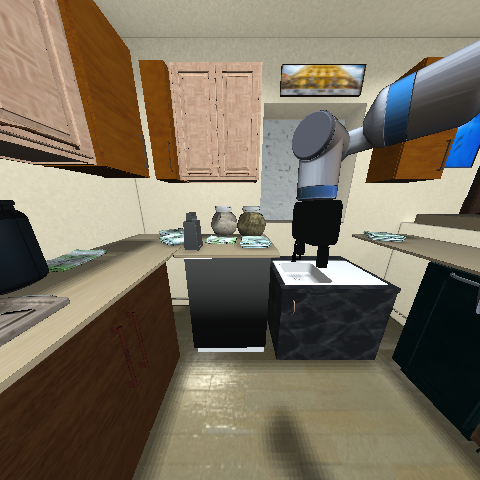

--- bowl.n.01_1 ---
 basic: {'is_near': False, 'is_visible': False, 'is_reachable': False, 'is_holding': False, 'is_movable': True, 'is_openable': False}
 on top of: {'bowl.n.01_2': False, 'cabinet.n.01_1': False, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': False}
 inside of: {'cabinet.n.01_1': True, 'cabinet.n.01_2': False}
--- bowl.n.01_2 ---
 basic: {'is_near': False, 'is_visible': False, 'is_reachable': False, 'is_holding': False, 'is_movable': True, 'is_openable': False}
 on top of: {'bowl.n.01_1': False, 'cabinet.n.01_1': False, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': False}
 inside of: {'cabinet.n.01_1': True, 'cabinet.n.01_2': False}
--- cabinet.n.01_1 ---
 basic: {'is_near': False, 'is_visible': False, 'is_reachable': False, 'is_holding': False, 'is_movable': False, 'is_openable': True, 'is_open': False}
--- cabinet.n.01_2 ---


In [31]:
# 1. Take list of every object except agent and floor
from igibson.primitives_utils import get_task_objects
from igibson import object_states

obj_names = get_task_objects(sim_env.env)
print(obj_names)

# TODO: Make methods from all this stuff

def get_obj_from_name(sim_env, obj_name):
    return sim_env.env.task.object_scope[obj_name] 

def _is_near(sim_env, obj_name):
    obj = get_obj_from_name(sim_env, obj_name)
    return sim_env._get_distance_from_robot(obj.get_position()) < sim_env.ROBOT_DISTANCE_THRESHOLD

def _is_visible(sim_env, obj_name):
    obj = get_obj_from_name(sim_env, obj_name)
    return obj.states[object_states.IsVisible].get_value(env=sim_env.env)

def _is_reachable(sim_env, obj_name):
    is_visible = _is_visible(sim_env, obj_name)
    is_near = _is_near(sim_env, obj_name)
    return is_visible and is_near

# Here obviously we can make a better job to compute all is_holding predicates at once,
# by going for exclusion
def _is_holding(sim_env, obj_name): # this is from the POV of the robot/agent, not the obj
    obj = get_obj_from_name(sim_env, obj_name)
    is_holding = sim_env._get_obj_in_hand() is obj
    return is_holding

def _is_movable(sim_env, obj_name):
    obj = get_obj_from_name(sim_env, obj_name)
    
    GUARANTEED_GRASPABLE_WIDTH = 0.1 # expose constant somewhere, or import from grasp_planning_utils

    # Get extensions of the bounding box of the object 
    bbox_center_in_world, bbox_quat_in_world, bbox_extent_in_base_frame, _ = obj.get_base_aligned_bounding_box(visual=False)
    
    # If at least one axis of the bbox of the object is smaller than the gripper of the robot, assume the object can be grapsed
    return np.any(bbox_extent_in_base_frame < GUARANTEED_GRASPABLE_WIDTH)
    
def _is_openable(sim_env, obj_name):
    obj = get_obj_from_name(sim_env, obj_name)
    is_openable = object_states.Open in obj.states
    return is_openable

def _is_open(sim_env, obj_name):
    if _is_openable(sim_env, obj_name):
        obj = get_obj_from_name(sim_env, obj_name)
        return obj.states[object_states.Open].get_value() 
    else:
        return None # Default return when predicate is not applicable

def _is_ontop(sim_env, obj_name, obj_below_name):
    obj = get_obj_from_name(sim_env, obj_name)
    obj_below = get_obj_from_name(sim_env, obj_below_name)

    # Only ask for movable objects
    if _is_movable(sim_env, obj_name):
        is_ontop = obj.states[object_states.OnTop].get_value(obj_below) 
        return is_ontop
    else:
        return None

def _is_inside(sim_env, obj_name, container_name):
    obj = get_obj_from_name(sim_env, obj_name)
    container_obj = get_obj_from_name(sim_env, container_name)

    # Only ask for movable objects
    if _is_movable(sim_env, obj_name) and _is_openable(sim_env, container_name):
        is_inside = obj.states[object_states.Inside].get_value(container_obj) 
        return is_inside
    else:
        return None

def compute_all_predicates(sim_env, obj_name):
    """
    Returns a dict of all predicates for `obj_name`.  The keys are:
      - 'is_near', 'is_visible', 'is_reachable', 'is_holding',
        'is_movable', 'is_openable', 'is_open'
      - 'is_ontop'   : { other_obj_name: bool or None, ... }
      - 'is_inside' : { other_obj_name: bool or None, ... }
    """
    preds = {}
    # basic unary predicates
    preds['is_near']      = _is_near(sim_env, obj_name)
    preds['is_visible']   = _is_visible(sim_env, obj_name)
    preds['is_reachable'] = _is_reachable(sim_env, obj_name)
    preds['is_holding']   = _is_holding(sim_env, obj_name)
    preds['is_movable']   = _is_movable(sim_env, obj_name)
    preds['is_openable']  = _is_openable(sim_env, obj_name)
    preds['is_open']      = _is_open(sim_env, obj_name)

    # prepare all other object‐names to test against
    all_objs = get_task_objects(sim_env.env)
    # drop the agent, floor, and the object itself
    targets = [o for o in all_objs if o not in {'agent', 'floor', obj_name}]

    # binary predicates: one entry per target object
    preds['is_ontop']  = {t: _is_ontop(sim_env, obj_name, t) for t in targets}
    preds['is_inside'] = {t: _is_inside(sim_env, obj_name, t) for t in targets}

    return preds

def compute_all_predicates(sim_env, obj_name):
    """
    Returns a dict of all non-None predicates for `obj_name`.
    Unary preds are top-level keys; 'is_ontop' and 'is_inside' are sub-dicts
    mapping target object → bool, only if the bool is not None.
    """
    preds = {}

    # --- unary predicates ---
    uni_funcs = {
        'is_near':      _is_near,
        'is_visible':   _is_visible,
        'is_reachable': _is_reachable,
        'is_holding':   _is_holding,
        'is_movable':   _is_movable,
        'is_openable':  _is_openable,
        'is_open':      _is_open,
    }
    for key, fn in uni_funcs.items():
        val = fn(sim_env, obj_name)
        if val is not None:
            preds[key] = val

    # find all other objects to test against
    all_objs = get_task_objects(sim_env.env)
    targets = [o for o in all_objs if o not in {'agent', 'floor', obj_name}]

    # --- binary predicates ---
    # only keep those entries whose value != None
    ontop_dict = {
        t: _is_ontop(sim_env, obj_name, t)
        for t in targets
    }
    ontop_dict = {t: v for t, v in ontop_dict.items() if v is not None}
    if ontop_dict:
        preds['is_ontop'] = ontop_dict

    inside_dict = {
        t: _is_inside(sim_env, obj_name, t)
        for t in targets
    }
    inside_dict = {t: v for t, v in inside_dict.items() if v is not None}
    if inside_dict:
        preds['is_inside'] = inside_dict

    return preds


render_utils.render_frame(sim_env.env)

for name in get_task_objects(sim_env.env):
    d = compute_all_predicates(sim_env, name)
    print(f"--- {name} ---")
    print(" basic:", {k: d[k] for k in d.keys() if k in ['is_near','is_visible','is_reachable','is_holding','is_movable','is_openable','is_open']})
    if 'is_ontop' in d.keys(): print(" on top of:",  d['is_ontop'])
    if 'is_inside' in d.keys():  print(" inside of:", d['is_inside'])

In [35]:
from collections import defaultdict

def compute_preds_by_predicate(sim_env):
    """
    Returns a dict mapping
      predicate_name → defaultdict(str_args → bool)
    """
    preds = defaultdict(dict)   # outer defaultdict: each key gives you a normal dict

    all_objs = get_task_objects(sim_env.env)

    # unary predicates
    uni = {
        'is_near':      _is_near,
        'is_visible':   _is_visible,
        'is_reachable': _is_reachable,
        'is_holding':   _is_holding,
        'is_movable':   _is_movable,
        'is_openable':  _is_openable,
        'is_open':      _is_open,
    }
    for name in all_objs:
        for pred_name, fn in uni.items():
            val = fn(sim_env, name)
            if val is not None:
                preds[pred_name][name] = val

    # binary predicates
    bin_specs = {
        'is_ontop':  _is_ontop,
        'is_inside': _is_inside,
    }
    for pred_name, fn in bin_specs.items():
        # make this one a defaultdict as well, if you like:
        d = defaultdict(bool)
        for a in all_objs:
            for b in all_objs:
                if a == b:
                    continue
                val = fn(sim_env, a, b)
                if val is not None:
                    d[f"{a},{b}"] = val
        if d:
            preds[pred_name] = d

    return preds

In [36]:
state = compute_preds_by_predicate(sim_env)
state

defaultdict(dict,
            {'is_near': {'bowl.n.01_1': False,
              'bowl.n.01_2': False,
              'cabinet.n.01_1': False,
              'cabinet.n.01_2': False,
              'spoon.n.01_1': False,
              'spoon.n.01_2': False,
              'piece_of_cloth.n.01_1': False,
              'sink.n.01_1': False},
             'is_visible': {'bowl.n.01_1': False,
              'bowl.n.01_2': False,
              'cabinet.n.01_1': False,
              'cabinet.n.01_2': True,
              'spoon.n.01_1': False,
              'spoon.n.01_2': False,
              'piece_of_cloth.n.01_1': False,
              'sink.n.01_1': True},
             'is_reachable': {'bowl.n.01_1': False,
              'bowl.n.01_2': False,
              'cabinet.n.01_1': False,
              'cabinet.n.01_2': False,
              'spoon.n.01_1': False,
              'spoon.n.01_2': False,
              'piece_of_cloth.n.01_1': False,
              'sink.n.01_1': False},
             'is_holdi

### Official Demo

In [4]:
def print_symbolic_state(state):
    print("-"*76)
    print("Symbolic state: \n")
    for k in state:
        print(k, state[k])
    print("-"*76)

In [5]:
plan = [
    {'action':'go_to', 'params':{'obj_name':'cabinet.n.01_1'}},
    {'action':'open', 'params':{'obj_name':'cabinet.n.01_1'}}, # TODO: add better prompts for the outer loop + it's failing too often
    {'action':'grasp', 'params':{'obj_name':'bowl.n.01_1'}}, # TODO: make the grasp more realistic somehow 
    #{'action':'grasp', 'params':{'obj_name':'bowl.n.01_2'}},
    #{'action':'grasp', 'params':{'obj_name':'spoon.n.01_1'}},
    #{'action':'grasp', 'params':{'obj_name':'spoon.n.01_2'}},
    {'action':'go_to', 'params':{'obj_name':'sink.n.01_1'}},
    ]

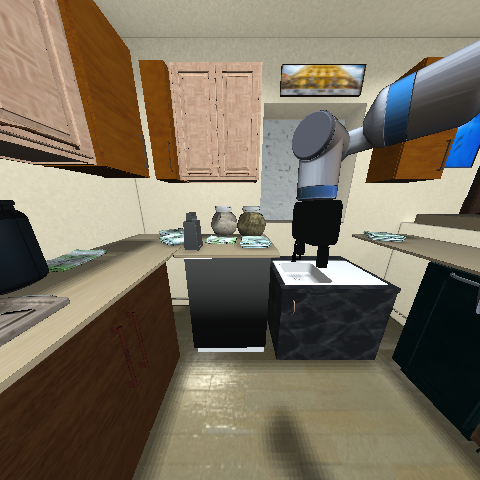

----------------------------------------------------------------------------
Symbolic state: 

is_near {'bowl.n.01_1': False, 'bowl.n.01_2': False, 'cabinet.n.01_1': False, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': False}
is_visible {'bowl.n.01_1': False, 'bowl.n.01_2': False, 'cabinet.n.01_1': False, 'cabinet.n.01_2': True, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': True}
is_reachable {'bowl.n.01_1': False, 'bowl.n.01_2': False, 'cabinet.n.01_1': False, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': False}
is_holding {'bowl.n.01_1': False, 'bowl.n.01_2': False, 'cabinet.n.01_1': False, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': False}
is_movable {'bowl.n.01_1': True, 'bowl.n.01_2': True, 'cabinet.n.01_1': False, 'cabi

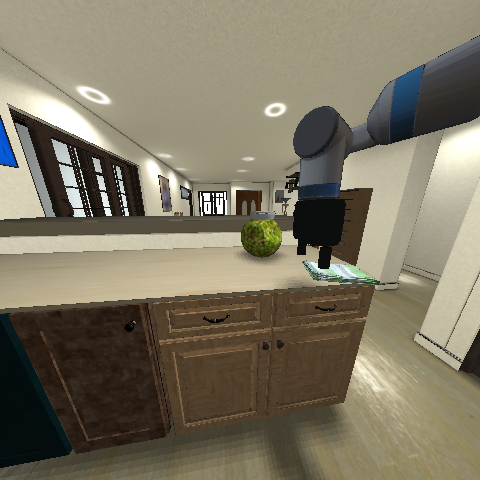

----------------------------------------------------------------------------
Symbolic state: 

is_near {'bowl.n.01_1': True, 'bowl.n.01_2': True, 'cabinet.n.01_1': True, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': False}
is_visible {'bowl.n.01_1': False, 'bowl.n.01_2': False, 'cabinet.n.01_1': True, 'cabinet.n.01_2': True, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': False}
is_reachable {'bowl.n.01_1': False, 'bowl.n.01_2': False, 'cabinet.n.01_1': True, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': False}
is_holding {'bowl.n.01_1': False, 'bowl.n.01_2': False, 'cabinet.n.01_1': False, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': False}
is_movable {'bowl.n.01_1': True, 'bowl.n.01_2': True, 'cabinet.n.01_1': False, 'cabinet.

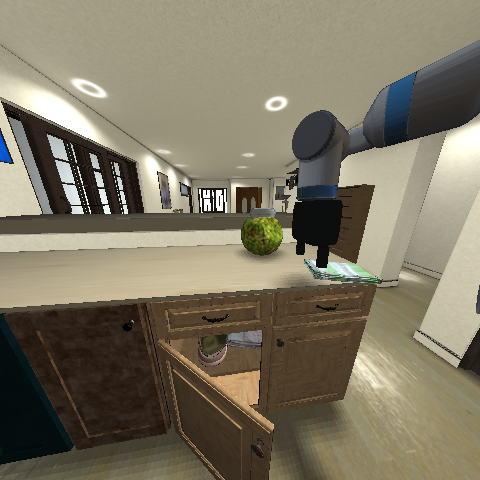

----------------------------------------------------------------------------
Symbolic state: 

is_near {'bowl.n.01_1': True, 'bowl.n.01_2': True, 'cabinet.n.01_1': True, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': True, 'sink.n.01_1': False}
is_visible {'bowl.n.01_1': True, 'bowl.n.01_2': True, 'cabinet.n.01_1': False, 'cabinet.n.01_2': True, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': True, 'sink.n.01_1': False}
is_reachable {'bowl.n.01_1': True, 'bowl.n.01_2': True, 'cabinet.n.01_1': False, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': True, 'sink.n.01_1': False}
is_holding {'bowl.n.01_1': False, 'bowl.n.01_2': False, 'cabinet.n.01_1': False, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': False}
is_movable {'bowl.n.01_1': True, 'bowl.n.01_2': True, 'cabinet.n.01_1': False, 'cabinet.n.01_

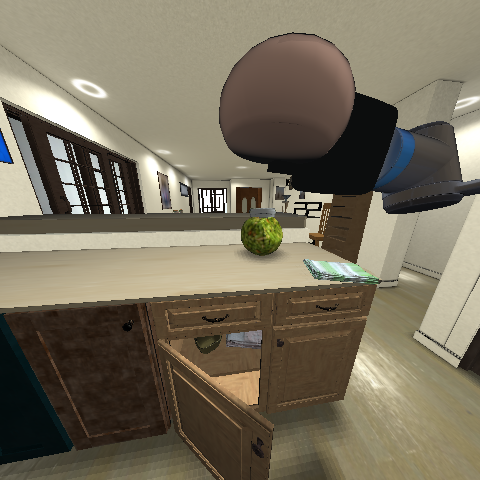

----------------------------------------------------------------------------
Symbolic state: 

is_near {'bowl.n.01_1': True, 'bowl.n.01_2': True, 'cabinet.n.01_1': True, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': True, 'sink.n.01_1': False}
is_visible {'bowl.n.01_1': True, 'bowl.n.01_2': True, 'cabinet.n.01_1': False, 'cabinet.n.01_2': True, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': True, 'sink.n.01_1': False}
is_reachable {'bowl.n.01_1': True, 'bowl.n.01_2': True, 'cabinet.n.01_1': False, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': True, 'sink.n.01_1': False}
is_holding {'bowl.n.01_1': True, 'bowl.n.01_2': False, 'cabinet.n.01_1': False, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': False}
is_movable {'bowl.n.01_1': True, 'bowl.n.01_2': True, 'cabinet.n.01_1': False, 'cabinet.n.01_2

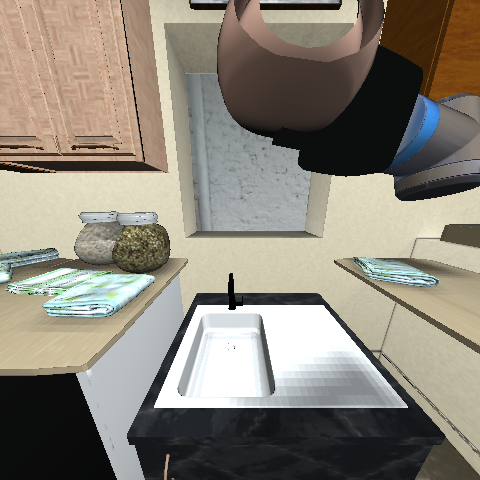

----------------------------------------------------------------------------
Symbolic state: 

is_near {'bowl.n.01_1': True, 'bowl.n.01_2': False, 'cabinet.n.01_1': False, 'cabinet.n.01_2': True, 'spoon.n.01_1': True, 'spoon.n.01_2': True, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': True}
is_visible {'bowl.n.01_1': False, 'bowl.n.01_2': False, 'cabinet.n.01_1': False, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': True}
is_reachable {'bowl.n.01_1': False, 'bowl.n.01_2': False, 'cabinet.n.01_1': False, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': True}
is_holding {'bowl.n.01_1': True, 'bowl.n.01_2': False, 'cabinet.n.01_1': False, 'cabinet.n.01_2': False, 'spoon.n.01_1': False, 'spoon.n.01_2': False, 'piece_of_cloth.n.01_1': False, 'sink.n.01_1': False}
is_movable {'bowl.n.01_1': True, 'bowl.n.01_2': True, 'cabinet.n.01_1': False, 'cabinet.n.

In [6]:
image, symbolic_state = sim_env.get_state_and_image()

image.show()
print_symbolic_state(symbolic_state)

for action in plan:
    try:
        success, image, symbolic_state = sim_env.apply_action(action)
        print(f'Action {action} executed. Success: {success}')
        
        image.show()
        print_symbolic_state(symbolic_state)
        
        legal = True
        
    except ValueError as e:
        print(f"Action {action} failed: {e}")
        success = False
        legal = False